# Support Vector Machine Solvers

### Description

Given $m$ data points $x_i \in \mathbb{R}^n$ with labels $y_i \in \{−1, 1\}$. We aim to solve 
the classification problem 

\begin{align}
\mathrm{minimize} \enspace & \frac{1}{2} \lVert w\rVert_2^2 + C\mathbf{1}^\top z
    \hspace{2cm}\\
\mathrm{subject\thinspace to} \enspace & y_i(w^\top x_i) \ge 1-z_i, i = 1, ..., m
    \hspace{2cm}\\
& z \ge 0
\end{align}

in the variables $w \in \mathbb{R}^n, z \in \mathbb{R}^m$, and its dual. Solving this problem trains a classifier vector $w$ such that, up to some errors

\begin{align}
w^\top x_i > 0 &\enspace \mathrm{when}\enspace y_i = 1 \\
w^\top x_i < 0 &\enspace \mathrm{when}\enspace y_i = −1.
\end{align}

This classifier can then be used to classify new points $x$ as positives or negatives by simply computing the scalar product $w^\top x$.

### Dual

We can also form the dual problem

\begin{align}
\mathrm{maximize} \enspace & 
    -\frac{1}{2} \lVert \sum_{i=1}^m \alpha_i y_i x_i\rVert_2^2 + \mathbf{1}^\top \alpha
    \hspace{2cm}\\
\mathrm{subject\thinspace to} \enspace & 0 \le \alpha \le C
    \hspace{2cm}
\end{align}

in the variable $\alpha\in\mathbb{R}^m$.

Solving the dual problem solves the primal problem at the same time since we know that at the optimum, we must have

$$ w = \sum_{i=1}^m \alpha_i y_i x_i.$$

If we note $X$ the data matrix with rows $x_i$, the dual can then be written as

\begin{align}
\mathrm{maximize} \enspace & 
    -\frac{1}{2} \alpha^{\top}\mathrm{diag}(y)XX^{\top}\mathrm{diag}(y)\alpha
    + \mathbf{1}^\top \alpha
    \hspace{2cm}\\
\mathrm{subject\thinspace to} \enspace & 0 \le \alpha \le C.
    \hspace{2cm}
\end{align}

The data only appears through the matrix $XX^T$. We are thus able to solve the dual by the kernel tricks. This is particularly useful when the dimension $n$ of the feature space is very high.

### Barrier Method

At each centering step we want to minimize the function $tf + \phi$ where

\begin{align}
f &= \frac{1}{2} \lVert w\rVert_2^2 + C\mathbf{1}^\top z, \\
\phi &= -\sum_{i=1}^m(\log(y_i(w^\top x_i)+z_i-1) + \log(z_i)).
\end{align}

We need thus to compute its gradient and Hessian for each Newton step. The detailed implementation can be found in the file `barrier.jl`. To test the algoritm, I'll sample data from two bivariate Gaussian distributions with different moments. Some useful functions are defined in `common.jl`.

In [150]:
using Distributions
using Plots
pyplot()

include("barrier.jl")
include("common.jl")

plotdualitygap (generic function with 1 method)

Start with an easy example where the generated data for the two classes have high probability to be linearly separable.


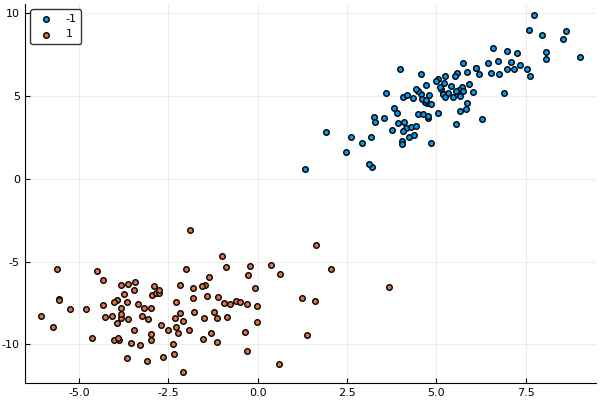

In [156]:
numdatapoints = 100
gaussianA = MvNormal([5.; 5.], [2. 2.; 2. 3.])
gaussianB = MvNormal([-2.; -8.], [5. 1.; 1. 3.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)


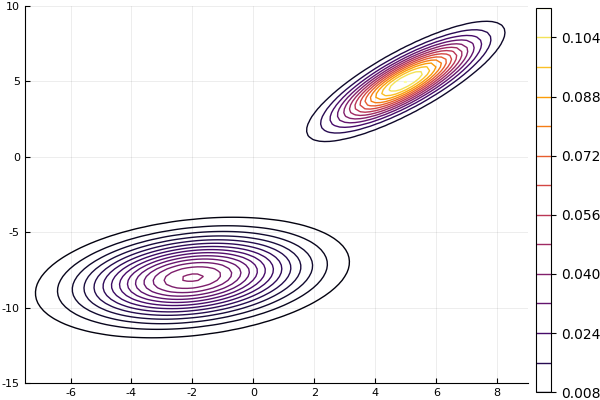

In [152]:
xs = linspace(-7.5, 9, 100)
ys = linspace(-15, 10, 100)
contour(xs, ys, (x, y) -> pdf(gaussianA, [x; y]))
contour!(xs, ys, (x, y) -> pdf(gaussianB, [x; y]))

Compute the line that separates the two classes of data and plot duality gap versus iteration number.

In [157]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
w, alpha, numstepsarray = svmbarrier(X, Y, 10, 1e-4)

([-0.346742, -0.461406, -0.279189], [1.67392e-9, 2.19702e-9, 2.10798e-9, 2.48006e-9, 2.5635e-9, 3.92499e-9, 3.12681e-9, 1.8206e-9, 2.08067e-9, 1.93636e-9  …  2.13102e-9, 2.08304e-9, 2.04335e-9, 1.94727e-9, 1.73517e-9, 2.50952e-9, 2.47374e-9, 2.56476e-9, 1.98485e-9, 2.19756e-9], [44, 45, 63, 21, 21])


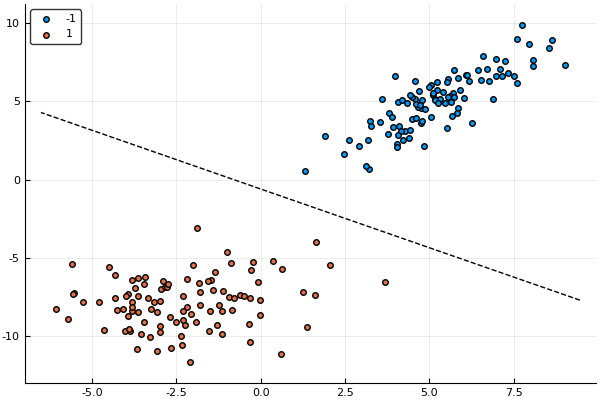

In [158]:
plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)


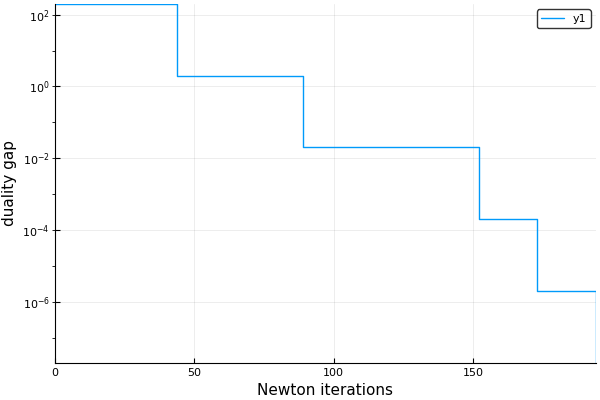

In [159]:
plotdualitygap(2*numdatapoints, 100., numstepsarray)

In [160]:
C = 10
Q = Diagonal(Y)*X*X'*Diagonal(Y)
primal(w) = sum(w.^2)/2 + C*sum(max.(0, ones(Y)-Y.*(X*w)))
dual(α) = -α⋅(Q*α)/2 + sum(α)

primal(w) - dual(alpha)

0.20553519965903183

Run the algorithm with different values of C and measure out-of-sample performance. However, probably since the problem to solve is too easy here, we don't see a great different between the use of different Cs.

In [121]:
for C in [1e-5, 1e-3, 1, 10, 100, 1000]
    w, alpha, numstepsarray = svmbarrier(X, Y, C, 1e-4)
    println("When C = $C, the error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
end

When C = 1.0e-5, the error rate is 0.000639
When C = 0.001, the error rate is 0.000686
When C = 1.0, the error rate is 0.000874
When C = 10.0, the error rate is 0.000834
When C = 100.0, the error rate is 0.00084
When C = 1000.0, the error rate is 0.000855


Now try with another example where the generated data are most of the time not linearly separable.


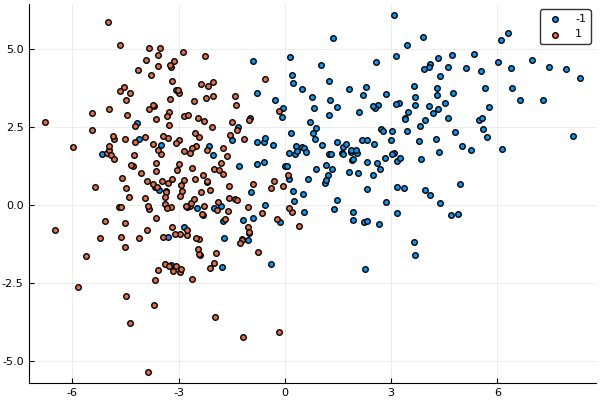

In [122]:
numdatapoints = 200
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)


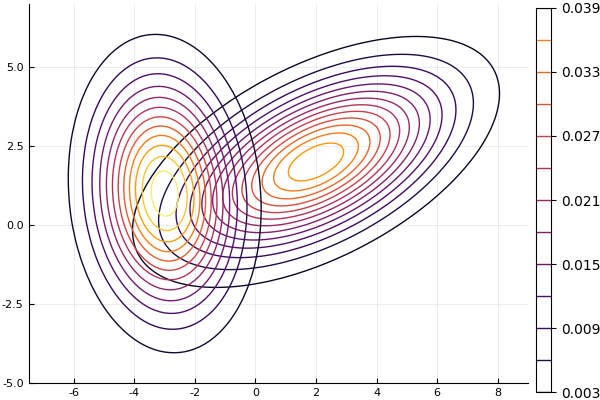

In [123]:
xs = linspace(-7.5, 9, 100)
ys = linspace(-5, 7, 100)
contour(xs, ys, (x, y) -> pdf(gaussianA, [x; y]))
contour!(xs, ys, (x, y) -> pdf(gaussianB, [x; y]))


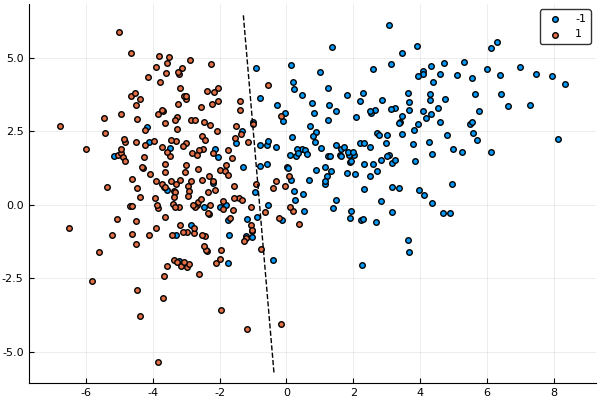

In [124]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
w, alpha, numstepsarray = svmbarrier(X, Y, 100, 1e-4)

plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)

In [125]:
for C in [1e-5, 1e-3, 1, 10, 100, 1000]
    w, alpha, numstepsarray = svmbarrier(X, Y, C, 1e-4)
    println("When C = $C, the error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
end

When C = 1.0e-5, the error rate is 0.225137
When C = 0.001, the error rate is 0.227428
When C = 1.0, the error rate is 0.20481
When C = 10.0, the error rate is 0.204591
When C = 100.0, the error rate is 0.204536
When C = 1000.0, the error rate is 0.204393


Again, we still don't see great differences in term of the performance when different value of C is chosen, but the results seems to suggest that greater the C, better the separating line we'll get. In fact, C measures the penalization of misclassifiying a point and choosing a C sufficiently large yields the hard-margin classifier for linearly separable data.

Nonetheless, it's also well-known that large C leads often to overfitting of the training data. This can be seen for some extremly cases in this setting.


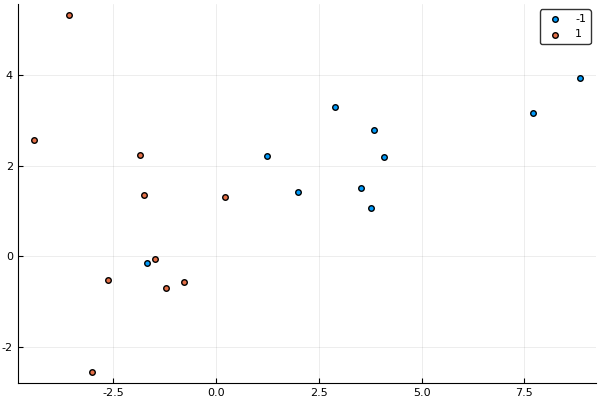

In [126]:
numdatapoints = 10
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)


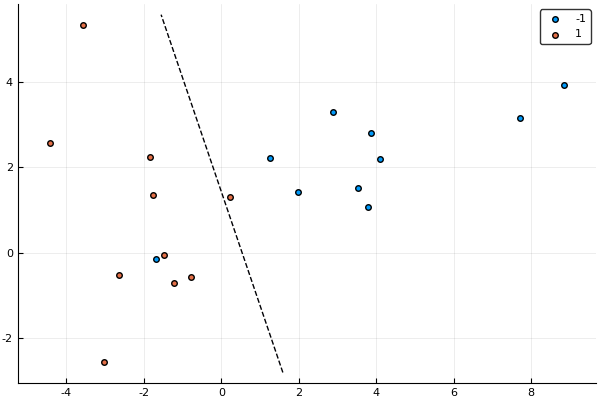

In [127]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]
w, alpha, numstepsarray = svmbarrier(X, Y, 100, 1e-4)

plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅w)

In [128]:
for C in [1e-5, 1e-3, 1, 10, 100, 1000]
    w, alpha, numstepsarray = svmbarrier(X, Y, C, 1e-4)
    println("When C = $C, the error rate is $(errorrate(gaussianA, gaussianB, w, Int(1e6)))")
end

When C = 1.0e-5, the error rate is 0.224978
When C = 0.001, the error rate is 0.225979
When C = 1.0, the error rate is 0.2563
When C = 10.0, the error rate is 0.256342
When C = 100.0, the error rate is 0.257288
When C = 1000.0, the error rate is 0.256486


As predicted, since we have few training data here. When they fail to describe properly the underlying model a large value of C can cause overfitting and thus deteriorate the out-of-sample performance of the classifier. In contrast, choosing a small value of C (in this case samller than 0.001) sometimes allows us to get around this problem.

### Compare with different Solvers

In this section I'll try to use some off-the-shelf solvers to solve the classification problem and compare their performances with the previous implementation.

In [1]:
import SVR

In [91]:
numdatapoints = 500
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
X = [cloudA cloudB]'
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]

1000-element Array{Float64,1}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮  
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [93]:
using JuMP
using Ipopt

model = Model(solver=IpoptSolver(tol=0.001))

@variables model begin
    w[1:2]
    b
    z[1:1000], (lowerbound=0)
end

@objective(model, Min, (sum(w.^2)+b^2)/2+10*sum(z))
@constraint(model, con, Y.*X*w + b .≥ 1 - z)

@time status = solve(model)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4000
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:     1003
                     variables with only lower bounds:     1000
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

:Optimal

In [95]:
@time model = SVR.train(Y, X', svm_type=Int32(0), kernel_type=Int32(0))

  0.009558 seconds (36 allocations: 71.922 KiB)


SVR.svmmodel(Ptr{SVR.svm_model} @0x00007f4571981400, SVR.svm_parameter(0, 0, 3, 0.5, 0.0, 100.0, 0.001, 1.0, 0, Ptr{Int32} @0x0000000000000000, Ptr{Float64} @0x0000000000000000, 0.5, 0.1, 1, 0), SVR.svm_problem(1000, Ptr{Float64} @0x00007f457204c540, Ptr{Ptr{SVR.svm_node}} @0x00007f45725fb180), SVR.svm_node[SVR.svm_node(1, 3.22915) SVR.svm_node(1, -1.23165) … SVR.svm_node(1, -3.66262) SVR.svm_node(1, -5.64416); SVR.svm_node(2, 4.47176) SVR.svm_node(2, 1.4176) … SVR.svm_node(2, 4.9688) SVR.svm_node(2, 2.65379); SVR.svm_node(-1, NaN) SVR.svm_node(-1, NaN) … SVR.svm_node(-1, NaN) SVR.svm_node(-1, NaN)])

Since with the Julia interface of libsvm, it's quite painful to get the value of the support vector (dealing with C pointers etc.), I just show here that the classification performance is comparable with what we have seen before.

In [7]:
fieldnames(model)

4-element Array{Symbol,1}:
 :plibsvmmodel
 :param       
 :problem     
 :nodes       

In [8]:
fieldnames(unsafe_load(model.plibsvmmodel))

12-element Array{Symbol,1}:
 :param     
 :nr_class  
 :l         
 :SV        
 :sv_coef   
 :rho       
 :probA     
 :probB     
 :sv_indices
 :label     
 :nSV       
 :free_sv   

In [9]:
cs = unsafe_load(model.plibsvmmodel).s

Ptr{Ptr{Float64}} @0x0000000007d4fa90

In [59]:
numtestpoints = 10000
testA = rand(gaussianA, numtestpoints)
testB = rand(gaussianB, numtestpoints)
X = [testA testB]
Y = [-1.*ones(numtestpoints); ones(numtestpoints)]
predict(x) = SVR.predict(model, x)
sum(mapslices(predict, X, 1)'.≠Y)/numtestpoints

0.2059

### Coordinate Descent

We can also solve the dual problem by using the coordinate descent method and recover the primal solution thanks to the representer theorem.

In [143]:
include("dualcoordinatedescent.jl")

svm_dualcoordinatedescentopt (generic function with 2 methods)


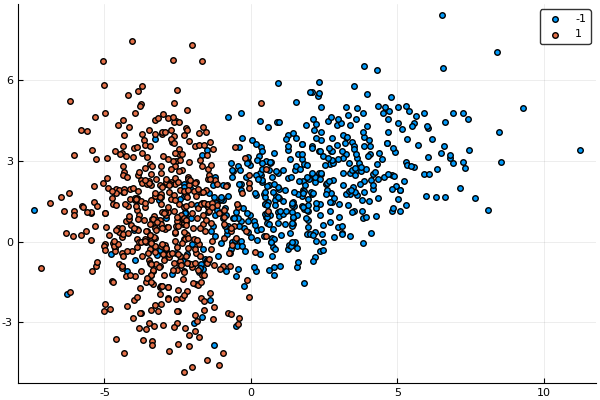

In [132]:
numdatapoints = 500
gaussianA = MvNormal([2.; 2.], [7. 2.5; 2.5 3.])
gaussianB = MvNormal([-3.; 1.], [2. -0.3; -0.3 5.])
cloudA = rand(gaussianA , numdatapoints)
cloudB = rand(gaussianB, numdatapoints)
plotclouds(cloudA, cloudB)

In [133]:
X = [[cloudA cloudB]' ones(2*numdatapoints)]
Y = [-1.*ones(numdatapoints); ones(numdatapoints)]

1000-element Array{Float64,1}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮  
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [141]:
@time w, α, dualitygaps = svm_dualcoordinatedescent(X, Y, 10, 1, 5000)

 22.128285 seconds (34.95 M allocations: 40.067 GiB, 16.96% gc time)


([-1.02519, 0.0804907, -1.00379], [0.0, 10.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0], [1.70852e8, 6.73377e5, 3.08399e5, 1.58599e5, 1.02567e5, 70858.2, 49816.6, 37369.4, 28724.3, 21852.9  …  170.026, 169.988, 169.951, 169.914, 169.877, 169.839, 169.802, 169.765, 169.728, 169.69])

In [145]:
@time we, α = svm_dualcoordinatedescentopt(X, Y, 10, 1e-4, 5000)

  3.437252 seconds (18.23 M allocations: 1.600 GiB, 5.96% gc time)


([-0.842858, -0.0129024, -0.814983], [0.0, 10.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0], 15.785883467000849, 0.07720351535499503)

In [146]:
@time ww, alpha, numstepsarray = svmbarrier(X, Y, 10, 1)

 19.903004 seconds (2.01 M allocations: 13.823 GiB, 25.33% gc time)


([-0.842869, -0.0129146, -0.814988], [4.04289e-5, -3.94708e-5, 4.69646e-5, 0.000136448, 6.0255e-5, 1.49587e-5, 6.2059e-5, 7.19426e-5, 1.51907e-5, 2.63438e-5  …  4.29415e-5, 8.70996e-5, 3.01373e-5, -0.00036148, 7.34706e-5, 8.21389e-5, 3.75419e-5, 3.25425e-5, 4.83587e-5, -0.00226634], [51, 99, 47])


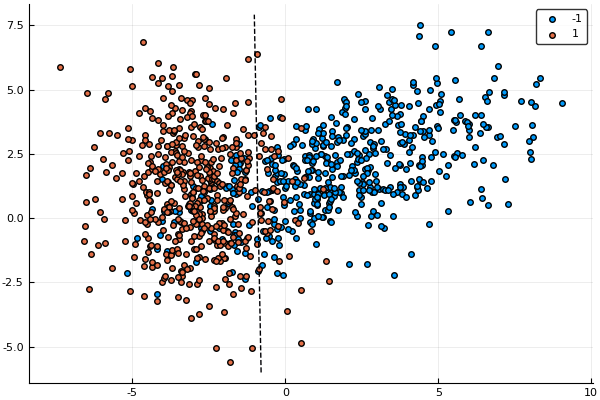

In [118]:
plotclouds(cloudA, cloudB)
drawborder((x, y) -> [x; y; 1]⋅we)


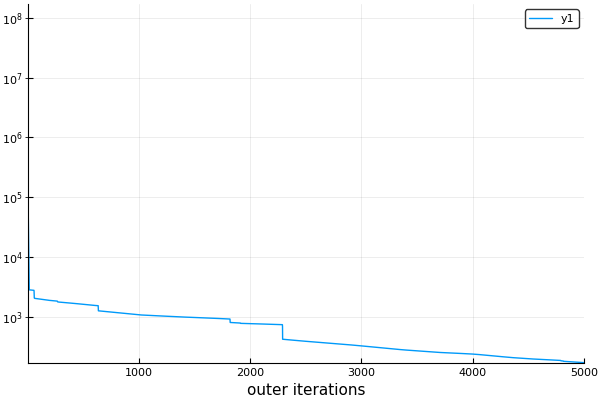

In [142]:
plot(dualitygaps, yscale=:log10, xlabel="outer iterations")

In [113]:
using JuMP
using Ipopt

model = Model(solver=IpoptSolver(tol=1e-7))

@variables model begin
    w[1:3]
    z[1:1000], (lowerbound=0)
end

@objective(model, Min, sum(w.^2)/2+10*sum(z))
@constraint(model, con, Y.*X*w .≥ 1 - z)

@time status = solve(model)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     4000
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:     1003
                     variables with only lower bounds:     1000
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

:Optimal

In [98]:
getdual(con)

1000-element Array{Float64,1}:
 9.99999   
 6.46941e-6
 2.85409e-6
 6.92698e-6
 3.99667e-6
 9.99997   
 9.99998   
 4.66213e-5
 9.99997   
 3.98631e-6
 2.43905e-6
 3.93584e-5
 3.00476e-6
 ⋮         
 9.99995   
 3.76056e-6
 9.30256   
 9.99999   
 2.56412e-5
 1.10037e-5
 4.04837e-5
 9.99999   
 1.94262e-5
 5.41624e-6
 7.87895e-6
 8.23162e-6

In [123]:
norm(getdual(con)-α)

7.033365163442626

In [122]:
norm(getvalue(w)-we)

0.005048629587711951

In [147]:
C = 10
Q = Diagonal(Y)*X*X'*Diagonal(Y)
primal(w) = sum(w.^2)/2 + C*sum(max.(0, ones(Y)-Y.*(X*w)))
dual(α) = -α⋅(Q*α)/2 + sum(α)

dual (generic function with 1 method)

In [115]:
primal(getvalue(w)) - dual(getdual(con))

9.084472367248964e-6

In [149]:
primal(we)- dual(α)

0.07720351535499503

In [148]:
primal(ww)- dual(alpha)

2642.5592056922806